# Downloads e Imports


In [ ]:
!pip install deap
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 974.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
# Importando as bibliotecas necessárias
import random
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.utils import to_categorical

In [ ]:
# Carregando o conjunto de dados MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Pré-processamento dos dados
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
def custom_crossover(ind1, ind2):
    # Realize o crossover entre os dois arrays
    crossover_point = random.randint(1, len(ind1) - 1)
    offspring1 = ind1[:crossover_point] + ind2[crossover_point:]
    offspring2 = ind2[:crossover_point] + ind1[crossover_point:]
    return offspring1, offspring2

In [ ]:
# Função de avaliação para a CNN
def evaluate(individual):
    # Extrair hiperparâmetros do indivíduo
    f1, ks1, fa1, pt1, f2, ks3, fa2, pt2, nn, fa3, last = map(abs, individual)

    # Construir o modelo CNN
    model = Sequential()
    fa = 'relu'
    if fa1 == 1:
      fa = 'relu'
    elif fa1 == 2:
      fa = 'gelu'
    else:
      fa = 'softmax'

    model.add(Conv2D(abs(int(f1)), kernel_size=(int(ks1), int(ks1)), activation=fa, input_shape=(28, 28, 1)))

    if pt1 == 1:
      model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=(2, 2)))
    else:
      model.add(AveragePooling2D(pool_size=(2, 2), padding='valid', strides=(2, 2)))

    if fa2 == 1:
      fa = 'relu'
    elif fa2 == 2:
      fa = 'gelu'
    else:
      fa = 'softmax'
    model.add(Conv2D(abs(int(f2)), kernel_size=(int(ks3), int(ks3)), activation=fa))

    if pt2 == 1:
      model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=(2, 2)))
    else:
      model.add(AveragePooling2D(pool_size=(2, 2), padding='valid', strides=(2, 2)))

    model.add(Flatten())

    if fa3 == 1:
      fa = 'relu'
    elif fa3 == 2:
      fa = 'gelu'
    elif fa3 == 3:
      fa = 'softmax'
    else:
      fa = 'sigmoid'

    model.add(Dense(int(nn), activation=fa))

    if last == 1:
      fa = 'softmax'
    else:
      fa = 'sigmoid'

    model.add(Dense(10, activation=fa))

    # Compilar o modelo
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Treinar o modelo e avaliar no conjunto de teste
    model.fit(X_train, y_train, epochs=5, verbose=0)
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

    return accuracy,

In [ ]:
results = {}

In [ ]:
# Configuração do problema de maximização
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Inicialização de parâmetros do algoritmo genético
toolbox = base.Toolbox()
toolbox.register("filt_number_1", lambda: int(random.choice([32, 64, 128, 256])))  # Intervalo para o número de filtros
toolbox.register("kernel_size_1", lambda: int(random.choice([3, 5, 7])))  # Tamanho do filtro
toolbox.register("ativation_func_1", lambda: random.choice([1,2,3]))  # Função de ativação 1
toolbox.register("pooling_type_1", random.randint, 1, 2)  # Intervalo para o número de filtros
toolbox.register("kernel_size_2", random.randint, 2, 3)  # Intervalo para o número de filtros
toolbox.register("filt_number_2", lambda: int(random.choice([8, 16, 32, 64])))  # Intervalo para o número de filtros
toolbox.register("kernel_size_3", lambda: int(random.choice([2, 3, 4])))  # Tamanho do filtro
toolbox.register("ativation_func_2", lambda: random.choice([1,2,3,4]))  # Função de ativação 2
toolbox.register("saida",  lambda: random.choice([1,2]))  # ultima camada

toolbox.register("individual", tools.initCycle, creator.Individual, (
  toolbox.filt_number_1, toolbox.kernel_size_1, toolbox.ativation_func_1,
  toolbox.pooling_type_1,
  toolbox.filt_number_2, toolbox.kernel_size_1, toolbox.ativation_func_1,
  toolbox.pooling_type_1,
  toolbox.filt_number_1, toolbox.ativation_func_2,
  toolbox.saida), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registro de operadores genéticos
toolbox.register("mate", custom_crossover) #chance de juntar
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2) #chance de mutar
toolbox.register("select", tools.selTournament, tournsize=3) #batle royal de reprodução
toolbox.register("evaluate", evaluate) #função que vai rodar

# Criar população inicial
population = toolbox.population(n=10)

# Executar diferentes algoritmos genéticos
results['eaSimple'] = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=5, stats=None, halloffame=None, verbose=True)
# print(results)

# Exibir o melhor indivíduo (melhor conjunto de hiperparâmetros)
best_individual = tools.selBest(results['eaSimple'][0], k=1)[0]
print(f"\nMelhor conjunto de hiperparâmetros para eaSimple:", best_individual)

# Base de daos

In [ ]:
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
# Carregando o conjunto de dados MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Pré-processamento dos dados
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Carregando o conjunto de dados MNIST
(X_train_f, y_train_f), (X_test_f, y_test_f) = fashion_mnist.load_data()

# Pré-processamento dos dados
X_train_f = X_train_f.reshape(X_train_f.shape[0], 28, 28, 1).astype('float32') / 255
X_test_f = X_test_f.reshape(X_test_f.shape[0], 28, 28, 1).astype('float32') / 255
y_train_f = to_categorical(y_train_f, 10)
y_test_f = to_categorical(y_test_f, 10)

### Tentativa fazendo manualmente

In [ ]:
# Função para criar o modelo de CNN com parâmetros variáveis
def create_model(filters1, kernel_size1, activation1, pool_type1, pool_size1,
                 filters2, kernel_size2, activation2, pool_type2, pool_size2,
                 dense_neurons, dense_activation, output_activation):

  model = models.Sequential()

  model.add(layers.Conv2D(filters=filters1, kernel_size=kernel_size1, activation=activation1, input_shape=(28,28,1)))

  if pool_type1 == 'max':
    model.add(layers.MaxPooling2D(pool_size=pool_size1, padding='valid', strides=(2, 2)))
  elif pool_type1 == 'avg':
    model.add(layers.AveragePooling2D(pool_size=pool_size1, padding='valid', strides=(2, 2)))

  model.add(layers.Conv2D(filters=filters2, kernel_size=kernel_size2, activation=activation2))

  if pool_type2 == 'max':
    model.add(layers.MaxPooling2D(pool_size=pool_size2, padding='valid', strides=(2, 2)))
  elif pool_type2 == 'avg':
    model.add(layers.AveragePooling2D(pool_size=pool_size2, padding='valid', strides=(2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(units=dense_neurons, activation=dense_activation))
  model.add(layers.Dense(units=10, activation=output_activation))

  return model

In [ ]:
# Função de avaliação do modelo
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=0)
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    return accuracy

In [ ]:
def fitness(params):
    filters1, kernel_size1, activation1, pool_type1, pool_size1, \
    filters2, kernel_size2, activation2, pool_type2, pool_size2, \
    dense_neurons, dense_activation, output_activation = params

    model = create_model(filters1, kernel_size1, activation1, pool_type1, pool_size1,
                         filters2, kernel_size2, activation2, pool_type2, pool_size2,
                         dense_neurons, dense_activation, output_activation)

    X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    accuracy = evaluate_model(model, X_train_partial, y_train_partial, X_val, y_val)

    return accuracy

In [ ]:
def generate_population(population_size):
  population = []

  for _ in range(population_size):
    kernel_size1 = np.random.choice([3, 5, 7])
    kernel_size2 = np.random.choice([3, 5, 7])

    pool_size1 = np.random.choice([2, 3])
    pool_size2 = np.random.choice([2, 3, 4])

    individual = [
      np.random.choice([32, 64, 128, 256]),  # filters1
      (kernel_size1, kernel_size1),  # kernel_size1
      np.random.choice(['relu', 'gelu', 'softmax']),  # activation1

      np.random.choice(['max', 'avg']),  # pool_type1
      (pool_size1, pool_size1),  # pool_size1

      np.random.choice([8, 16, 32, 64]),  # filters2
      (kernel_size2, kernel_size2),  # kernel_size2
      np.random.choice(['relu', 'gelu', 'softmax']),  # activation2

      np.random.choice(['max', 'avg']),  # pool_type2
      (pool_size2, pool_size2),  # pool_size2

      np.random.choice([32, 64, 128, 256]),  # dense_neurons
      np.random.choice(['relu', 'gelu', 'softmax', 'sigmoid']),  # dense_activation

      np.random.choice(['sigmoid', 'softmax'])  # output_activation
    ]
    population.append(individual)

  return population

In [ ]:
def crossover(parent1, parent2):
  crossover_point = np.random.randint(1, len(parent1) - 1)
  child1 = parent1[:crossover_point] + parent2[crossover_point:]
  child2 = parent2[:crossover_point] + parent1[crossover_point:]
  return child1, child2

In [ ]:
def mutate(individual, mutation_rate):
  for i in range(len(individual)):
    if np.random.rand() < mutation_rate:
      if i == 0 or i == 10:
        individual[i] = np.random.choice([32, 64, 128, 256]) # filters1 ou dense_neuros
      elif i == 1 or i == 6:
        kernel_size = np.random.choice([3, 5, 7])
        individual[i] = (kernel_size, kernel_size)
      elif i == 2 or i == 7:
        individual[i] = np.random.choice(['relu', 'gelu', 'softmax']) # activation conv2d
      elif i == 3 or i == 8:
        individual[i] = np.random.choice(['max', 'avg']) # pool type
      elif i == 4:
        pool_size = np.random.choice([2, 3])
        individual[i] = (pool_size, pool_size)
      elif i == 5:
        individual[i] = np.random.choice([8, 16, 32, 64]) # filters2
      elif i == 9:
        pool_size = np.random.choice([2, 3, 4])
        individual[i] = (pool_size, pool_size)
      elif i == 11:
        individual[i] = np.random.choice(['relu', 'gelu', 'softmax', 'sigmoid']) # dense_activation
      elif i == 12:
        individual[i] = np.random.choice(['sigmoid', 'softmax']) # output_activation

  return individual

In [ ]:
def genetic_algorithm(X_train, y_train, population_size, generations, mutation_rate):
  population = generate_population(population_size)

  for generation in range(generations):
    scores = []

    for individual in population:
      score = fitness(individual)
      scores.append((individual, score))

    scores.sort(key=lambda x: x[1], reverse=True)
    top_individuals = [individual for individual, score in scores[:10]]
    # top_individuals = np.array(top_individuals, dtype=object)

    new_population = []

    for _ in range(population_size // 2):
      # parent1 = np.random.choice(top_individuals)
      # parent2 = np.random.choice(top_individuals)
      parent1 = top_individuals[np.random.randint(len(top_individuals))]
      parent2 = top_individuals[np.random.randint(len(top_individuals))]
      child1, child2 = crossover(parent1, parent2)
      child1 = mutate(child1, mutation_rate)
      child2 = mutate(child2, mutation_rate)

      # print(parent1)
      # print(parent2)
      # print(child1)
      # print(child2)

      new_population.extend([child1, child2])

    population = new_population

    print(f"Generation {generation + 1}, Best Accuracy: {scores[0][1]}")

  best_params = scores[0][0]
  return best_params

In [ ]:
population_size = 10
generations = 5
mutation_rate = 0.1

In [ ]:
best_hyperparameters = genetic_algorithm(X_train, y_train, population_size, generations, mutation_rate)

print("Melhores hiperparâmetros encontrados:")
print(best_hyperparameters)

Generation 1, Best Accuracy: 0.9891666769981384
Generation 2, Best Accuracy: 0.9885833263397217
Generation 3, Best Accuracy: 0.9896666407585144
Generation 4, Best Accuracy: 0.9902499914169312
Generation 5, Best Accuracy: 0.9893333315849304
Melhores hiperparâmetros encontrados:
[64, (7, 7), 'gelu', 'max', (2, 2), 64, (5, 5), 'gelu', 'max', (3, 3), 128, 'gelu', 'sigmoid']


In [ ]:
best_hyperparameters_f = genetic_algorithm(X_train_f, y_train_f, population_size, generations, mutation_rate)

print("Melhores hiperparâmetros encontrados para Fashion MNIST:")
print(best_hyperparameters)

Generation 1, Best Accuracy: 0.9867500066757202
Generation 2, Best Accuracy: 0.9887499809265137
Generation 3, Best Accuracy: 0.9893333315849304
Generation 4, Best Accuracy: 0.984083354473114
Generation 5, Best Accuracy: 0.9877499938011169
Melhores hiperparâmetros encontrados para Fashion MNIST:
[64, (7, 7), 'gelu', 'max', (2, 2), 64, (5, 5), 'gelu', 'max', (3, 3), 128, 'gelu', 'sigmoid']


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.set(style='whitegrid')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()

In [ ]:
def create_and_evaluate_model(best_hyperparameters, X_train, y_train, X_test, y_test):
  filters1, kernel_size1, activation1, pool_type1, pool_size1, \
  filters2, kernel_size2, activation2, pool_type2, pool_size2, \
  dense_neurons, dense_activation, output_activation = best_hyperparameters

  model = models.Sequential()

  model.add(layers.Conv2D(filters=filters1, kernel_size=kernel_size1, activation=activation1, input_shape=(28,28,1)))

  if pool_type1 == 'max':
    model.add(layers.MaxPooling2D(pool_size=pool_size1, padding='valid', strides=(2, 2)))
  elif pool_type1 == 'avg':
    model.add(layers.AveragePooling2D(pool_size=pool_size1, padding='valid', strides=(2, 2)))

  model.add(layers.Conv2D(filters=filters2, kernel_size=kernel_size2, activation=activation2))

  if pool_type2 == 'max':
    model.add(layers.MaxPooling2D(pool_size=pool_size2, padding='valid', strides=(2, 2)))
  elif pool_type2 == 'avg':
    model.add(layers.AveragePooling2D(pool_size=pool_size2, padding='valid', strides=(2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(units=dense_neurons, activation=dense_activation))
  model.add(layers.Dense(units=10, activation=output_activation))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

  # Avaliar o modelo nos dados de teste
  loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
  print(f"Acurácia do modelo nos dados de teste: {accuracy}")

  # Matriz de confusão
  y_pred = model.predict(X_test)

  y_test_classes = np.argmax(y_test, axis=1)
  y_pred_classes = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_test_classes, y_pred_classes)
  print("Matriz de Confusão:")
  plot_confusion_matrix(cm, [0,1,2,3,4,5,6,7,8,9])

  # Gráfico do loss
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_303 (Conv2D)         (None, 22, 22, 64)        3200      
                                                                 
 max_pooling2d_143 (MaxPool  (None, 11, 11, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_304 (Conv2D)         (None, 7, 7, 64)          102464    
                                                                 
 max_pooling2d_144 (MaxPool  (None, 3, 3, 64)          0         
 ing2D)                                                          
                                                                 
 flatten_151 (Flatten)       (None, 576)               0         
                                                                 
 dense_302 (Dense)           (None, 128)            

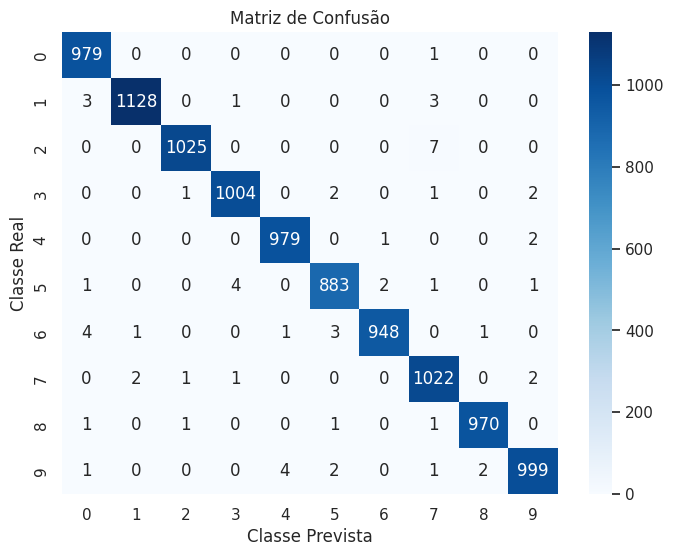

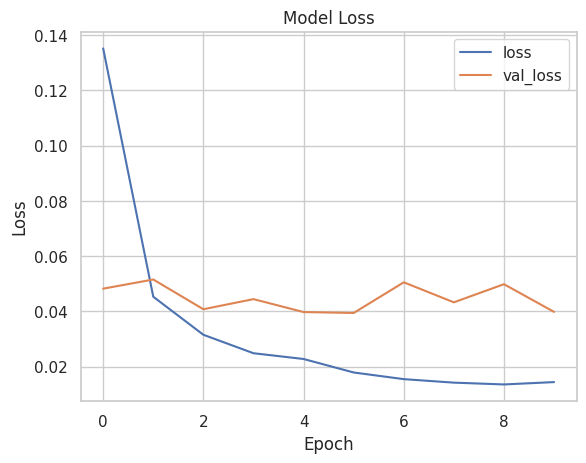

In [ ]:
create_and_evaluate_model(best_hyperparameters, X_train, y_train, X_test, y_test)

Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_305 (Conv2D)         (None, 22, 22, 64)        3200      
                                                                 
 average_pooling2d_159 (Ave  (None, 11, 11, 64)        0         
 ragePooling2D)                                                  
                                                                 
 conv2d_306 (Conv2D)         (None, 9, 9, 32)          18464     
                                                                 
 max_pooling2d_145 (MaxPool  (None, 4, 4, 32)          0         
 ing2D)                                                          
                                                                 
 flatten_152 (Flatten)       (None, 512)               0         
                                                                 
 dense_304 (Dense)           (None, 64)             

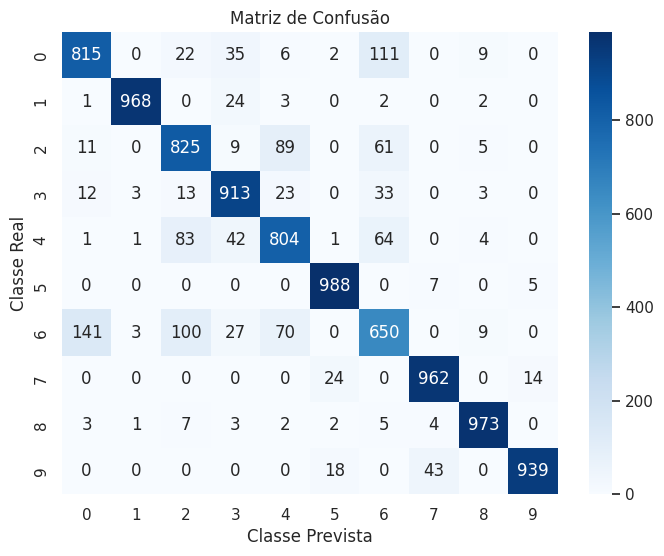

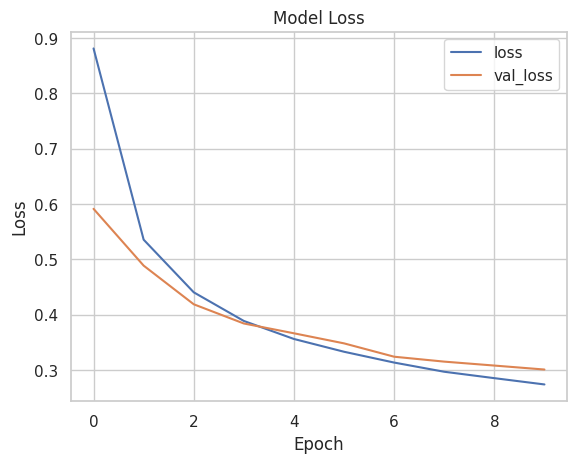

In [ ]:
create_and_evaluate_model(best_hyperparameters_f, X_train_f, y_train_f, X_test_f, y_test_f)

Model: "sequential_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_308 (Conv2D)         (None, 22, 22, 81)        4050      
                                                                 
 max_pooling2d_147 (MaxPool  (None, 11, 11, 81)        0         
 ing2D)                                                          
                                                                 
 conv2d_309 (Conv2D)         (None, 5, 5, 64)          254080    
                                                                 
 average_pooling2d_160 (Ave  (None, 2, 2, 64)          0         
 ragePooling2D)                                                  
                                                                 
 flatten_153 (Flatten)       (None, 256)               0         
                                                                 
 dense_306 (Dense)           (None, 256)            

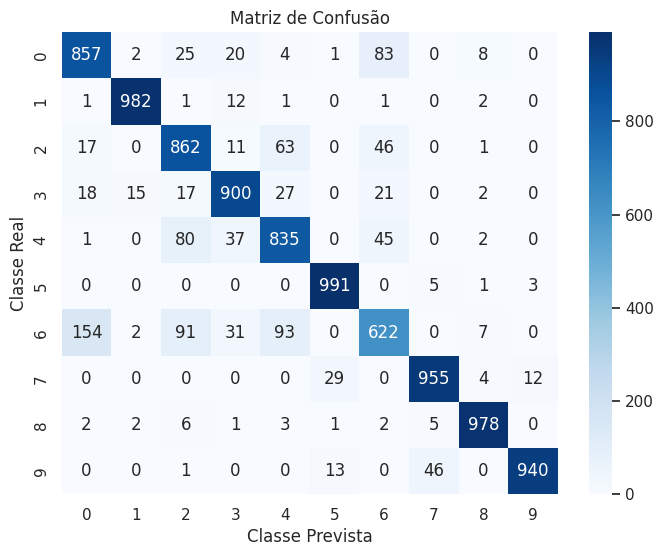

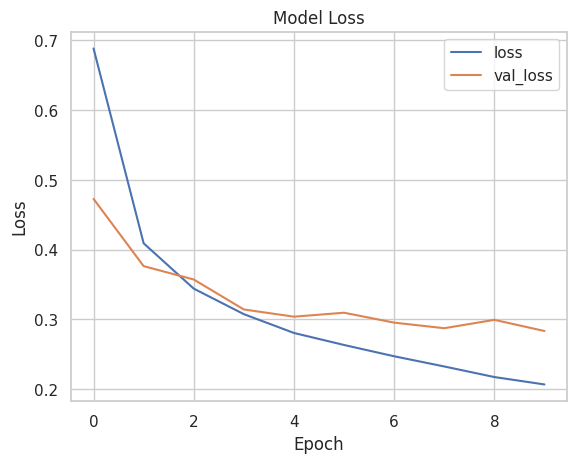

In [ ]:
fmnistEaSimples = [81, (7, 7), 'relu', 'max', (2, 2), 64, (7, 7), 'softmax', 'avg', (2, 2), 256, 'relu', 'sigmoid']
create_and_evaluate_model(fmnistEaSimples, X_train_f, y_train_f, X_test_f, y_test_f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 219)       10950     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 219)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 35)          375620    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 35)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 140)               0         
                                                                 
 dense (Dense)               (None, 50)                7

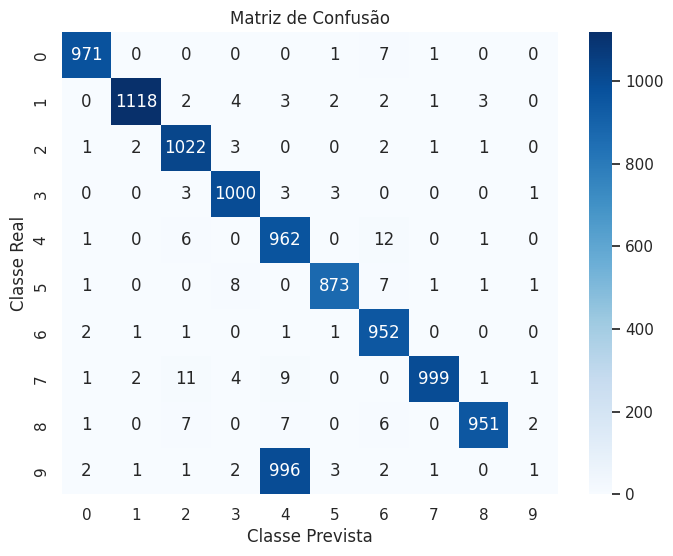

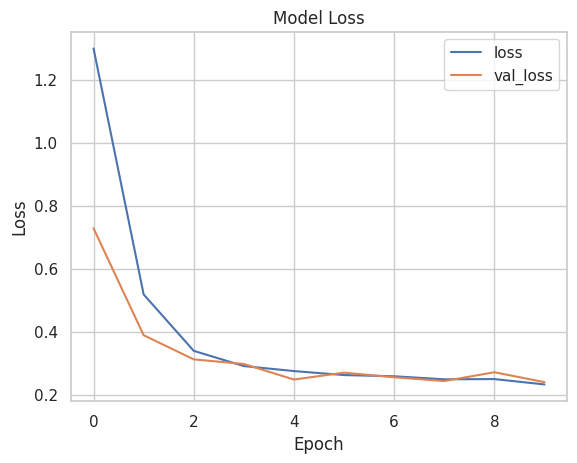

In [ ]:
mnistEaSimples = [219, (7, 7), 'gelu', 'max', (2, 2), 35, (7, 7), 'gelu', 'max', (2, 2), 50, 'softmax', 'softmax']
create_and_evaluate_model(mnistEaSimples, X_train, y_train, X_test, y_test)